In [1]:
#https://ieeexplore.ieee.org/document/10549889

In [2]:
!pip install openpyxl ssqueezepy

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.2/127.2 kB 11.0 MB/s eta 0:00:00


In [3]:
# !pip install --upgrade tensorflow

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.applications import ResNet50
from ssqueezepy import cwt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt
import pywt
import matplotlib.pyplot as plt

2024-12-09 16:54:07.567259: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-09 16:54:07.567354: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-09 16:54:07.567399: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 16:54:07.577752: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
import keras.models
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [6]:
# Load datasets
ppg_data_combined = pd.read_excel('combined_dataset.xlsx')

print(ppg_data_combined)

     Num.  subject_ID Sex(M/F)  Age(year)  Height(cm)  Weight(kg)  \
0       1           2   Female         45         152          63   
1       1           2   Female         45         152          63   
2       1           2   Female         45         152          63   
3       2           3   Female         50         157          50   
4       2           3   Female         50         157          50   
..    ...         ...      ...        ...         ...         ...   
652   218         418     Male         25         173          63   
653   218         418     Male         25         173          63   
654   219         419     Male         24         175          58   
655   219         419     Male         24         175          58   
656   219         419     Male         24         175          58   

     Systolic Blood Pressure(mmHg)  Diastolic Blood Pressure(mmHg)  \
0                              161                              89   
1                              

In [7]:
# 참가자의 숫자 확인
print(ppg_data_combined['subject_ID'].nunique())

219


The dataset provided by Liang et al. in their study is a valuable resource for non-invasive CVD detection, encompassing 657 data segments from 219 individuals.

In [8]:
data_systolic = ppg_data_combined["Systolic Blood Pressure(mmHg)"]
data_diastolic = ppg_data_combined["Diastolic Blood Pressure(mmHg)"]

ppg_data = ppg_data_combined.iloc[:,14:]

In [9]:
ppg_data = np.array(ppg_data)
print(ppg_data)

[[2438 2438 2438 ... 1827 1754 1754]
 [2201 2201 2171 ... 1997 1997 1997]
 [2019 2014 2014 ... 1924 1929 1929]
 ...
 [3083 3039 3071 ... 2422 2451 2379]
 [2426 2431 2446 ... 3103 3146 3151]
 [2691 2718 2743 ... 2611 2639 2623]]


In [10]:
# Assuming bp_data has columns 'systolic' and 'diastolic'
# Normalize blood pressure data
bp_data = np.array([data_systolic, data_diastolic]).T
print(bp_data)

[[161  89]
 [161  89]
 [161  89]
 ...
 [108  68]
 [108  68]
 [108  68]]


In [11]:
print(ppg_data.shape)
print(bp_data.shape)

(657, 2100)
(657, 2)


### 이상치 제거를 위한 Bandpass Filter와 Wavelet 변환

In [12]:
# Define Bandpass Filter
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data, axis=1)  # Filter along each row
    return filtered_data

In [13]:
# Define Wavelet Denoising
def denoise_wavelet(data, wavelet='db4', level=4):
    denoised_data = []
    for row in data:
        coeffs = pywt.wavedec(row, wavelet, mode='per')
        # Thresholding to remove noise
        for i in range(1, len(coeffs)):
            coeffs[i] = pywt.threshold(coeffs[i], value=np.std(coeffs[i]) * 0.5, mode='soft')
        denoised_row = pywt.waverec(coeffs, wavelet, mode='per')
        denoised_data.append(denoised_row[:len(row)])  # Trim to original length
    return np.array(denoised_data)

In [14]:
# Sampling frequency (Hz)
fs = 1000  # Assumed sampling frequency, adjust as per your data
lowcut = 0.5  # Minimum frequency (Hz)
highcut = 15.0  # Maximum frequency (Hz)

# Apply Bandpass Filter
ppg_bandpassed = bandpass_filter(ppg_data, lowcut, highcut, fs)

# Apply Wavelet Denoising
ppg_denoised = denoise_wavelet(ppg_bandpassed)

print("Shape after filtering:", ppg_denoised.shape)

Shape after filtering: (657, 2100)


### 원본 PPG와 잡음 제거 후 PPG 시각화

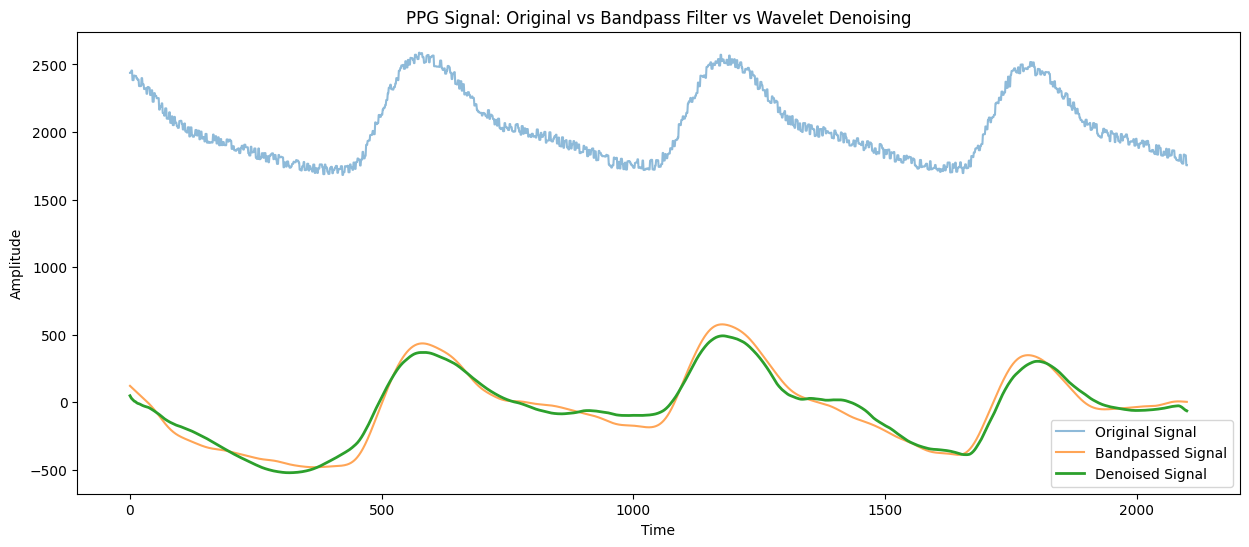

In [15]:
# Visualize original, filtered, and denoised data for a single PPG signal
sample_index = 0  # Choose a sample row to visualize

plt.figure(figsize=(15, 6))
plt.plot(ppg_data[sample_index], label="Original Signal", alpha=0.5)
plt.plot(ppg_bandpassed[sample_index], label="Bandpassed Signal", alpha=0.7)
plt.plot(ppg_denoised[sample_index], label="Denoised Signal", linewidth=2)
plt.legend()
plt.title("PPG Signal: Original vs Bandpass Filter vs Wavelet Denoising")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [16]:
# Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(ppg_denoised, bp_data, test_size=0.2, random_state=42)

print("Train/Test Split:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Train/Test Split:
X_train shape: (525, 2100), y_train shape: (525, 2)
X_test shape: (132, 2100), y_test shape: (132, 2)


In [17]:
# PPG Signal (2100, 1)으로 변환
X_train_lstm = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train_lstm = y_train
y_test_lstm = y_test

In [18]:
# Perform CWT transform
def CWT_transform(data):
    from ssqueezepy import cwt
    images = []
    for signal in data:
        Wx, _ = cwt(signal, wavelet='morlet')
        Wx = np.abs(Wx)
        Wx = (Wx - Wx.min()) / (Wx.max() - Wx.min())
        images.append(Wx)
    return np.array(images)

X_train_cwt = CWT_transform(X_train)
X_test_cwt = CWT_transform(X_test)
X_train_cwt = np.array([tf.image.resize(img[..., np.newaxis], [128, 128]).numpy() for img in X_train_cwt])
X_test_cwt = np.array([tf.image.resize(img[..., np.newaxis], [128, 128]).numpy() for img in X_test_cwt])

# Adjust shapes
X_train_cwt = X_train_cwt[:X_train_lstm.shape[0]]
X_test_cwt = X_test_cwt[:X_test_lstm.shape[0]]

/usr/local/lib/python3.10/dist-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
2024-12-09 16:56:03.630439: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38698 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:0b:00.0, compute capability: 8.0
2024-12-09 16:56:03.632802: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38698 MB memory:  -> device: 1, name: CUDA GPU, pci bus id: 0000:4c:00.0, compute capability: 8.0


In [19]:
# Debug final shapes
print("After Slicing:")
print(f"X_train_cwt shape: {X_train_cwt.shape}, X_train_lstm shape: {X_train_lstm.shape}")
print(f"y_train_lstm shape: {y_train_lstm.shape}")

After Slicing:
X_train_cwt shape: (525, 128, 128, 1), X_train_lstm shape: (525, 2100, 1)
y_train_lstm shape: (525, 2)


In [20]:
# Custom Loss Function
def custom_loss(y_true, y_pred):
    sbp_true, dbp_true = y_true[:, 0], y_true[:, 1]
    sbp_pred, dbp_pred = y_pred[:, 0], y_pred[:, 1]
    sbp_loss = tf.keras.losses.Huber(delta=10)(sbp_true, sbp_pred)
    dbp_loss = tf.keras.losses.Huber(delta=5)(dbp_true, dbp_pred)
    return 0.6 * sbp_loss + 0.4 * dbp_loss

In [21]:
# Transformer Encoder Layer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [22]:
# Transformer Model
def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, dropout=0.3):
    inputs = layers.Input(shape=input_shape, name="Transformer_Input")
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    x = layers.GlobalAveragePooling1D()(x)
    return inputs, x

In [23]:
# Update the build_combined_model function
def build_combined_model(cnn_input_shape, transformer_input_shape, transformer_params, output_dim=2):
    # Pre-trained CNN
    cnn_inputs = layers.Input(shape=cnn_input_shape, name="CNN_Input")
    
    # Replicate single channel to 3 channels
    replicated_inputs = layers.Concatenate()([cnn_inputs, cnn_inputs, cnn_inputs])  # Shape: (128, 128, 3)
    
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=replicated_inputs)
    x = layers.Flatten()(base_model.output)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    cnn_outputs = layers.Dense(128, activation='relu')(x)
    
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Transformer
    transformer_inputs, transformer_outputs = build_transformer_model(transformer_input_shape, **transformer_params)

    # Combine CNN and Transformer
    combined = layers.concatenate([cnn_outputs, transformer_outputs])
    x = layers.Dense(128, activation="relu")(combined)
    outputs = layers.Dense(output_dim, activation="linear", name="BP_Output")(x)
    model = Model(inputs=[cnn_inputs, transformer_inputs], outputs=outputs)
    return model

In [24]:
# Transformer Parameters
transformer_params = {
    "head_size": 64,
    "num_heads": 4,
    "ff_dim": 4,
    "num_transformer_blocks": 3,
    "dropout": 0.3,
}

# Define input shapes
cnn_input_shape = (128, 128, 1)  # Single-channel input
transformer_input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])

# Build the model
model = build_combined_model(cnn_input_shape, transformer_input_shape, transformer_params)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=custom_loss, metrics=['mae'])
model.summary()

94765736/94765736 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 CNN_Input (InputLayer)      [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 128, 128, 3)          0         ['CNN_Input[0][0]',           
                                                                     'CNN_Input[0][0]',           
                                                                     'CNN_Input[0][0]']           
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['concatenate[0][0]']         
                             

                                                                                                  
 conv2_block2_add (Add)      (None, 32, 32, 256)          0         ['conv2_block1_out[0][0]',    
                                                                     'conv2_block2_3_bn[0][0]']   
                                                                                                  
 conv2_block2_out (Activati  (None, 32, 32, 256)          0         ['conv2_block2_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 32, 32, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_blo

 D)                                                                                               
                                                                                                  
 conv3_block2_2_bn (BatchNo  (None, 16, 16, 128)          512       ['conv3_block2_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_2_relu (Activ  (None, 16, 16, 128)          0         ['conv3_block2_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 16, 16, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
          

 conv4_block1_1_bn (BatchNo  (None, 8, 8, 256)            1024      ['conv4_block1_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_1_relu (Activ  (None, 8, 8, 256)            0         ['conv4_block1_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_2_conv (Conv2  (None, 8, 8, 256)            590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 8, 8, 256)            1024      ['conv4_block1_2_conv[0][0]'] 
 rmalizati

                                                                                                  
 conv4_block3_3_bn (BatchNo  (None, 8, 8, 1024)           4096      ['conv4_block3_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block3_add (Add)      (None, 8, 8, 1024)           0         ['conv4_block2_out[0][0]',    
                                                                     'conv4_block3_3_bn[0][0]']   
                                                                                                  
 conv4_block3_out (Activati  (None, 8, 8, 1024)           0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_blo

 rmalization)                                                                                     
                                                                                                  
 conv4_block6_2_relu (Activ  (None, 8, 8, 256)            0         ['conv4_block6_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block6_3_conv (Conv2  (None, 8, 8, 1024)           263168    ['conv4_block6_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 8, 8, 1024)           4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
          

 D)                                                                                               
                                                                                                  
 layer_normalization_1 (Lay  (None, 2100, 1)              2         ['conv1d_1[0][0]']            
 erNormalization)                                                                                 
                                                                                                  
 conv5_block2_2_bn (BatchNo  (None, 4, 4, 512)            2048      ['conv5_block2_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 tf.__operators__.add_1 (TF  (None, 2100, 1)              0         ['layer_normalization_1[0][0]'
 OpLambda)                                                          , 'tf.__operators__.add[0][0]'
          

 D)                                                                                               
                                                                                                  
 layer_normalization_4 (Lay  (None, 2100, 1)              2         ['dropout_4[0][0]']           
 erNormalization)                                                                                 
                                                                                                  
 conv5_block3_3_bn (BatchNo  (None, 4, 4, 2048)           8192      ['conv5_block3_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 tf.__operators__.add_4 (TF  (None, 2100, 1)              0         ['layer_normalization_4[0][0]'
 OpLambda)                                                          , 'tf.__operators__.add_3[0][0
          

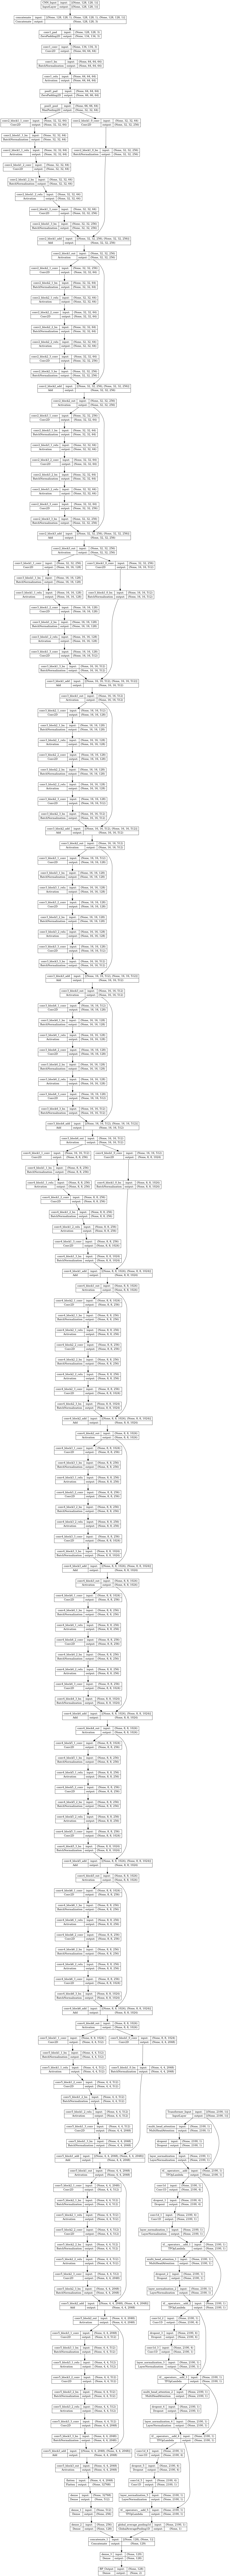

In [25]:
from tensorflow.keras.utils import plot_model

# 모델 시각화
plot_model(
    model,                   # 학습에 사용된 모델
    to_file="model_plot.png",  # 저장할 파일 이름
    show_shapes=True,         # 각 레이어의 출력 텐서 모양 표시
    show_layer_names=True,    # 레이어 이름 표시
    expand_nested=True,       # 중첩된 모델 (서브모델) 시각화
    dpi=96                    # 해상도 설정
)

In [26]:
# from tensorflow.keras.callbacks import EarlyStopping

# # Early stopping 설정
# early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

# # 모델 학습
# history = model.fit(
#     {"Transformer_Input": X_train_lstm, "CNN_Input": X_train_cwt},
#     {"BP_Output": y_train_lstm},
#     validation_split=0.2,
#     epochs=500,
#     batch_size=32,
#     callbacks=[early_stopping]
# )

In [27]:
# Train the model
history = model.fit(
    {"CNN_Input": X_train_cwt, "Transformer_Input": X_train_lstm},
    y_train_lstm,
    validation_split=0.2,
    epochs=100,
    batch_size=32
)

Epoch 1/100


2024-12-09 16:56:18.246074: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-12-09 16:56:19.737317: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fca3002ffc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-09 16:56:19.737390: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): CUDA GPU, Compute Capability 8.0
2024-12-09 16:56:19.737398: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): CUDA GPU, Compute Capability 8.0
2024-12-09 16:56:19.744318: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-09 16:56:19.830200: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/14 [==============================] - 15s 330ms/step - loss: 857.2341 - mae: 97.7059 - val_loss: 852.2556 - val_mae: 97.2274
Epoch 2/100
14/14 [==============================] - 3s 205ms/step - loss: 800.1277 - mae: 91.6801 - val_loss: 764.5449 - val_mae: 88.0626
Epoch 3/100
14/14 [==============================] - 3s 203ms/step - loss: 670.9424 - mae: 78.3291 - val_loss: 568.8502 - val_mae: 67.8919
Epoch 4/100
14/14 [==============================] - 3s 204ms/step - loss: 392.7795 - mae: 49.5926 - val_loss: 169.0200 - val_mae: 25.8901
Epoch 5/100
14/14 [==============================] - 3s 203ms/step - loss: 117.6141 - mae: 17.0062 - val_loss: 98.2846 - val_mae: 13.8412
Epoch 6/100
14/14 [==============================] - 3s 203ms/step - loss: 94.0456 - mae: 13.2157 - val_loss: 100.5588 - val_mae: 14.0786
Epoch 7/100
14/14 [==============================] - 3s 204ms/step - loss: 85.0173 - mae: 12.5540 - val_loss: 82.2483 - val_mae: 12.5230
Epoch 8/100
14/14 [=======================

14/14 [==============================] - 3s 205ms/step - loss: 81.7425 - mae: 12.1177 - val_loss: 80.8636 - val_mae: 12.3144
Epoch 61/100
14/14 [==============================] - 3s 205ms/step - loss: 82.1307 - mae: 12.1488 - val_loss: 82.5583 - val_mae: 12.4944
Epoch 62/100
14/14 [==============================] - 3s 205ms/step - loss: 81.6542 - mae: 12.0875 - val_loss: 82.4593 - val_mae: 12.5173
Epoch 63/100
14/14 [==============================] - 3s 205ms/step - loss: 82.9819 - mae: 12.2494 - val_loss: 80.4848 - val_mae: 12.2956
Epoch 64/100
14/14 [==============================] - 3s 205ms/step - loss: 81.0995 - mae: 12.0660 - val_loss: 85.9049 - val_mae: 12.8899
Epoch 65/100
14/14 [==============================] - 3s 205ms/step - loss: 81.6749 - mae: 12.1275 - val_loss: 80.5063 - val_mae: 12.2684
Epoch 66/100
14/14 [==============================] - 3s 204ms/step - loss: 80.8139 - mae: 12.0051 - val_loss: 89.9963 - val_mae: 13.2638
Epoch 67/100
14/14 [===========================

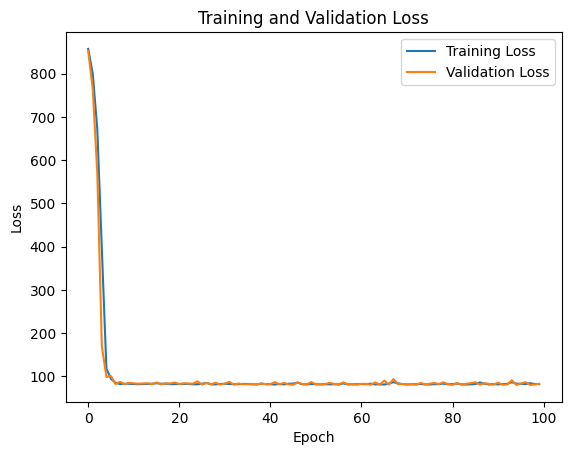

In [28]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [29]:
# Evaluate the model
test_loss, test_mae = model.evaluate(
    {"Transformer_Input": X_test_lstm, "CNN_Input": X_test_cwt},
    {"BP_Output": y_test_lstm}
)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")


5/5 [==============================] - 1s 73ms/step - loss: 84.0460 - mae: 12.4484
Test Loss: 84.04598236083984, Test MAE: 12.448427200317383


5/5 [==============================] - 1s 62ms/step


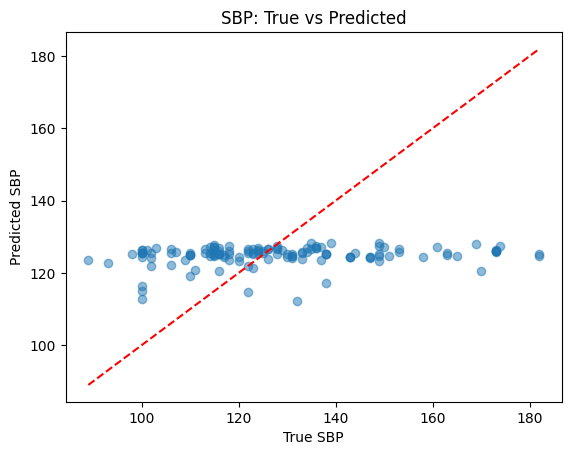

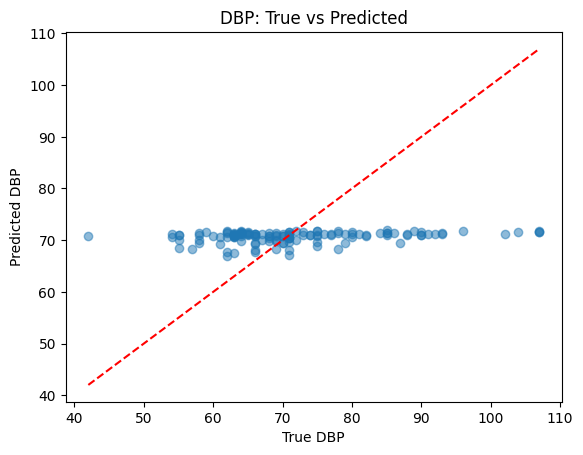

In [30]:
# Predict on test data
predictions = model.predict({"Transformer_Input": X_test_lstm, "CNN_Input": X_test_cwt})

# Compare predictions and true values
predicted_sbp = predictions[:, 0]
predicted_dbp = predictions[:, 1]
true_sbp = y_test_lstm[:, 0]
true_dbp = y_test_lstm[:, 1]

# Scatter plot
plt.scatter(true_sbp, predicted_sbp, alpha=0.5)
plt.plot([min(true_sbp), max(true_sbp)], [min(true_sbp), max(true_sbp)], color='red', linestyle='--')  # Add diagonal
plt.xlabel('True SBP')
plt.ylabel('Predicted SBP')
plt.title('SBP: True vs Predicted')
plt.show()

# Scatter plot for DBP
plt.scatter(true_dbp, predicted_dbp, alpha=0.5)
plt.plot([min(true_dbp), max(true_dbp)], [min(true_dbp), max(true_dbp)], color='red', linestyle='--')  # Add diagonal
plt.xlabel('True DBP')
plt.ylabel('Predicted DBP')
plt.title('DBP: True vs Predicted')
plt.show()



In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Evaluate SBP
mae_sbp = mean_absolute_error(true_sbp, predicted_sbp)
mse_sbp = mean_squared_error(true_sbp, predicted_sbp)
print(f"SBP - MAE: {mae_sbp}, MSE: {mse_sbp}")

# Evaluate DBP
mae_dbp = mean_absolute_error(true_dbp, predicted_dbp)
mse_dbp = mean_squared_error(true_dbp, predicted_dbp)
print(f"DBP - MAE: {mae_dbp}, MSE: {mse_dbp}")


SBP - MAE: 16.142944856123492, MSE: 431.18233960016437
DBP - MAE: 8.75390861973618, MSE: 136.1910811388185


In [32]:
predicted_sbp

array([121.9581  , 121.48488 , 127.49751 , 127.61102 , 125.425186,
       128.15767 , 120.709595, 124.9203  , 125.36615 , 125.27869 ,
       128.23222 , 124.30379 , 126.58396 , 126.62073 , 123.69437 ,
       119.05875 , 125.31011 , 127.09091 , 124.18373 , 125.54707 ,
       125.569466, 126.158905, 124.639   , 126.97264 , 124.43211 ,
       124.30896 , 125.891754, 127.54845 , 127.1533  , 114.65694 ,
       124.69069 , 126.90857 , 127.442795, 125.12735 , 126.65321 ,
       126.43364 , 126.98116 , 125.53653 , 125.96655 , 114.93849 ,
       126.83461 , 124.86246 , 125.06487 , 124.75208 , 124.77925 ,
       124.7894  , 126.76576 , 125.50687 , 125.97856 , 125.785835,
       125.24408 , 126.87916 , 127.05344 , 125.29155 , 126.453735,
       122.84645 , 125.131   , 122.108826, 127.16087 , 121.884415,
       123.40526 , 124.78784 , 124.37596 , 125.73863 , 125.493195,
       112.72504 , 126.001526, 125.03103 , 126.37555 , 126.61592 ,
       117.11897 , 125.825775, 127.539246, 126.63505 , 124.758

In [33]:
predicted_dbp

array([67.75558 , 69.936455, 71.53737 , 70.74793 , 71.79165 , 71.45246 ,
       69.550934, 70.776184, 71.25775 , 70.76502 , 71.21441 , 71.01949 ,
       70.0976  , 71.13421 , 68.434425, 68.81849 , 71.16425 , 70.44591 ,
       71.09392 , 71.22964 , 71.201614, 71.618904, 71.105934, 71.52805 ,
       71.22827 , 70.95585 , 71.16743 , 71.37415 , 71.21624 , 67.66698 ,
       71.4425  , 71.0286  , 71.619965, 71.06522 , 71.15108 , 71.00149 ,
       71.4493  , 71.28982 , 71.68099 , 67.545845, 71.38201 , 71.28819 ,
       71.10356 , 71.11297 , 71.503586, 71.02708 , 70.0483  , 71.08048 ,
       71.31336 , 71.33118 , 71.26651 , 71.16483 , 71.63332 , 71.38706 ,
       69.86972 , 68.24964 , 69.17643 , 70.11959 , 71.868385, 69.91415 ,
       68.30974 , 71.17042 , 70.729164, 71.80378 , 69.37629 , 67.22689 ,
       69.64454 , 71.12839 , 71.958046, 70.73019 , 68.03947 , 70.68304 ,
       70.4779  , 70.732735, 70.82041 , 70.89777 , 71.72013 , 71.54924 ,
       70.79283 , 70.63834 , 71.14241 , 70.89509 , 